# aSPEM Experiment : analysis


Test de différtentes pentes $k$ pour la relation entre $p_bet$ et $\hat{p}$


In [1]:
%run ../0_parameters.ipynb


WELCOME



In [2]:
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

# find_h_with_MI

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


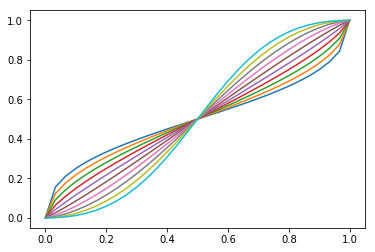

In [5]:
p = np.linspace(0, 1, 31)
def sigmoid(y):
    return 1 / (1 + np.exp(-y))
def logit(p):
    return np.log(p / (1 - p))
    
#plt.plot(p, sigmoid(4.*logit(p)))
for k in np.logspace(-1, 1, 10, base=2):
    plt.plot(p, sigmoid(k*logit(p)))

In [6]:
def r_(p, data) :
    
    p = np.ma.masked_array(p, mask=np.isnan(data)).compressed()
    data = np.ma.masked_array(data, mask=np.isnan(data)).compressed()

    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    
    return r_

In [7]:
def regress(ax, p, data, t_label=10, color='k', lw=2, axis=None) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    
    ax.plot(x_test, fitLine, c=color, linewidth=lw)

    if axis is None :
        x1, x2 = np.min(p), np.max(p)
        y1, y2 = np.min(data), np.max(data)
    else :
        x1, x2, y1, y2  = axis[0], axis[1], axis[2], axis[3]
    y_pos_r=y1+(y2-y1)/10 ; y_pos_m=y1+2*(y2-y1)/10
    ax.text(x2, y_pos_r, 'r = %0.3f'%(r_), color=color, fontsize=t_label/1.2, ha='right')
    
    return ax


In [8]:
# https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Weighted_correlation_coefficient
# https://stackoverflow.com/questions/38641691/weighted-correlation-coefficient-with-pandas
def r_weight(ax, x, y, w, t_label=10, color='k', lw=2, axis=None) :
    
    x = np.ma.masked_array(x, mask=np.isnan(y)).compressed()
    y = np.ma.masked_array(y, mask=np.isnan(y)).compressed()
    
    # Weighted Mean
    def m(x, w): return np.sum(x * w) / np.sum(w)
    # Weighted Covariance
    def cov(x, y, w): return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)
    # Weighted Correlation
    def corr(x, y, w): return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))    

    r = corr(x, y, w)
    
    if axis is None : x1, x2, y1, y2 = np.min(x), np.max(x), np.min(y), np.max(y)
    else :            x1, x2, y1, y2 = axis[0],   axis[1],   axis[2],   axis[3]
    
    y_pos_r=y1+(y2-y1)/10 ; y_pos_m=y1+2*(y2-y1)/10

    ax.text(x1, y_pos_r, 'r weight = %0.3f'%(r), color=color, fontsize=t_label/1.2, ha='left')
    
    return ax


In [9]:
Full = e.Full_list(modes_bcp=[])
modes_bcp = 'mean'
tau = np.arange(1, 603, 2)
list_h = 1/tau
#print(h)

r_k_s, h_k_s = {}, {}
for num, s in enumerate(list(set(Full.sujet))):
    print(s, end=' ')
    
    bet = Full['results'][Full.sujet==s].values.tolist()
    x = np.array(Full['bino'][Full.sujet==s].values.tolist())

    r_k, h_k = [], []
    for k in range(11) : r_k.append([]) ; h_k.append([])
    
    for num, k in enumerate(np.logspace(-1, 1, 10, base=2)) :
        
        r_bet_logit, r_bet_ = [], []
        for c in range(0, 3*200-150, 200) : r_bet_logit.append([]) ; r_bet_.append([])
        
        for h in list_h :

            for d, c in enumerate(range(0, 3*200-150, 200)) :
                x_100, p_hat_100 = x[c:c+200], np.zeros(200)

                liste = [0, 50, 100, 150, 200]
                for a in range(len(liste)-1) :
                    p_bar, r_bar, beliefs = bcp.inference(x_100[liste[a]:liste[a+1]], h=h, p0=.5, r0=1.)
                    p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                    p_hat_100[liste[a]:liste[a+1]] = p_hat_p

                if num==0 : r_bet_[d].append(r_(p_hat_100.tolist(), bet[c:c+200]))
                r_bet_logit[d].append(r_(sigmoid(k*logit(p_hat_100)), bet[c:c+200]))

        h_bet_logit, h_bet_ = [], []
        r_bet_l, r_bet = [], []
        for d, c in enumerate(range(0, 3*200-150, 200)) :

            if num==0 : h_bet_.append(list_h[np.argmax(r_bet_[d])])
            h_bet_logit.append(list_h[np.argmax(r_bet_logit[d])])

            if num==0 : r_bet.append(np.max(r_bet_[d]))
            r_bet_l.append(np.max(r_bet_logit[d]))
            

        #if num==0 : print('\nBet :\nh=', h_bet_, '\nr=', r_bet, end='\n\n\n')
        #print('\nBet Logit :', num, '-', k, '\nh=', h_bet_logit, '\nr=', r_bet_l, end='\n\n\n')
        
        if num==0 : h_k[0]=h_bet_; r_k[0]=r_bet
        h_k[num+1]=h_bet_logit ; r_k[num+1]=r_bet_l
        
    h_k_s[s], r_k_s[s] = h_k, r_k

CS 

/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


DC BMC SR IP TN YK OP FM AM RS LB 

Plot de R en fonction de la pente

CS
	sans logit :			avec logit (max r):
	b0: 	b1: 	b2:		b0: 	b1: 	b2:
k:					0.500,  0.680,  0.500
r:	0.449,  0.868,  0.809		0.471,  0.869,  0.813
h:	0.091,  0.143,  0.200		0.043,  0.143,  0.200
tau:	11, 	7, 	5		23, 	7, 	5


DC
	sans logit :			avec logit (max r):
	b0: 	b1: 	b2:		b0: 	b1: 	b2:
k:					0.500,  1.260,  1.080
r:	0.711,  0.885,  0.822		0.712,  0.886,  0.822
h:	0.333,  0.143,  0.091		0.333,  0.143,  0.091
tau:	3, 	7, 	11		3, 	7, 	11


BMC
	sans logit :			avec logit (max r):
	b0: 	b1: 	b2:		b0: 	b1: 	b2:
k:					0.926,  0.500,  0.794
r:	0.912,  0.949,  0.926		0.912,  0.955,  0.927
h:	0.030,  0.014,  0.026		0.032,  0.026,  0.026
tau:	33, 	71, 	39		31, 	39, 	39


SR
	sans logit :			avec logit (max r):
	b0: 	b1: 	b2:		b0: 	b1: 	b2:
k:					2.000,  2.000,  1.260
r:	0.846,  0.814,  0.932		0.865,  0.823,  0.934
h:	0.002,  0.002,  0.002		0.002,  0.002,  0.002
tau:	601, 	601, 	601		601, 	601, 	601


IP
	sans logit :			avec logit (max r):
	b0: 	b1: 	b2:		b0: 	b1: 	b2:
k:					0.500,  0.500

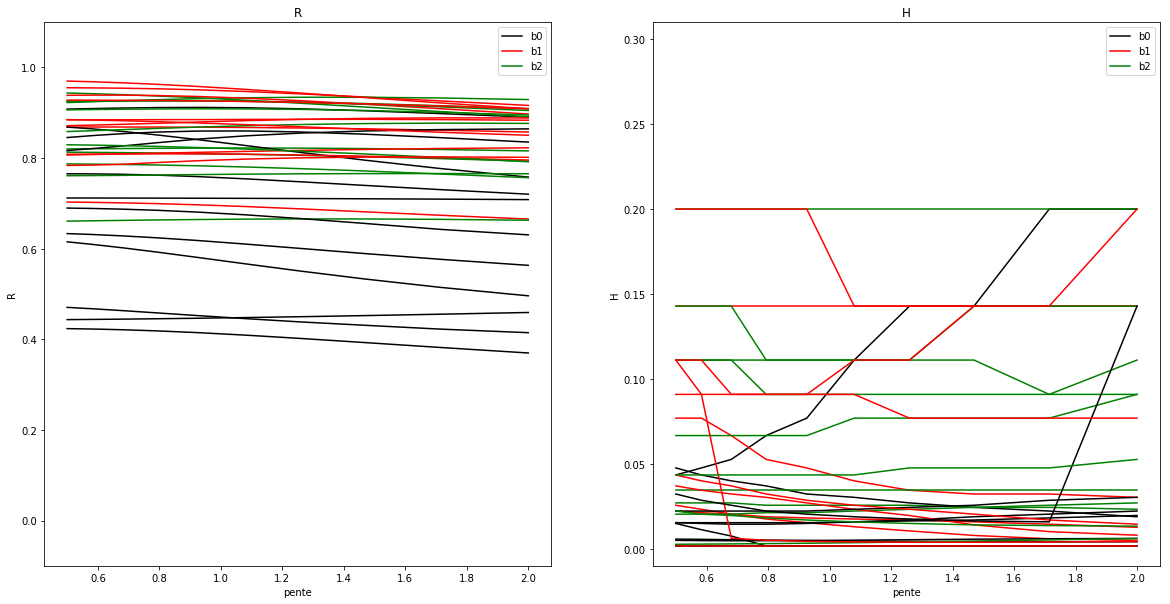

In [12]:
fig, ax = plt.subplots(1,2,figsize=(2*10,10))

list_k = np.logspace(-1, 1, 10, base=2)
for num, s in enumerate(h_k_s.keys()) :
    h_k, r_k = np.array(h_k_s[s]), np.array(r_k_s[s])
    
    r0, r1, r2 = np.max(r_k[:, 0]), np.max(r_k[:, 1]), np.max(r_k[:, 2])
    arg0, arg1, arg2 = np.argmax(r_k[:, 0]), np.argmax(r_k[:, 1]), np.argmax(r_k[:, 2])
    h0, h1, h2 = h_k[arg0, 0], h_k[arg1, 1], h_k[arg2, 2]
    
    if arg0==0 : k0 = 1
    else :       k0 = list_k[arg0-1]
        
    if arg1==0 : k1 = 1
    else :       k1 = list_k[arg1-1]
        
    if arg2==0 : k2 = 1
    else :       k2 = list_k[arg2-1]
    
    print(s)
    print('\tsans logit :\t\t\tavec logit (max r):')
    print('\tb0: \tb1: \tb2:\t\tb0: \tb1: \tb2:')
    print('k:\t\t\t\t\t%.3f,  %.3f,  %.3f'%(k0, k1, k2))
    print('r:\t%.3f,  %.3f,  %.3f\t\t%.3f,  %.3f,  %.3f'%(r_k[0,0], r_k[0,1], r_k[0,2], r0, r1, r2))
    print('h:\t%.3f,  %.3f,  %.3f\t\t%.3f,  %.3f,  %.3f'%(h_k[0,0], h_k[0,1], h_k[0,2], h0, h1, h2))
    print('tau:\t%.0f, \t%.0f, \t%.0f\t\t%.0f, \t%.0f, \t%.0f\n\n'%(1/h_k[0,0], 1/h_k[0,1], 1/h_k[0,2], 1/h0, 1/h1, 1/h2))

    for block, c in zip(range(3), ['k', 'r', 'g']) :
        ax[0].plot(list_k, r_k[1:,block], c=c, label='b%s'%block if num==0 else '')
        ax[1].plot(list_k, h_k[1:,block], c=c, label='b%s'%block if num==0 else '')

ax[0].set_ylim(-0.1, 1.1)
ax[1].set_ylim(-0.01, 0.31)
        
ax[0].set_title('R') ; ax[1].set_title('H')
ax[0].set_ylabel('R') ; ax[1].set_ylabel('H')
for a in range(2) : ax[a].legend() ; ax[a].set_xlabel('pente')

CS


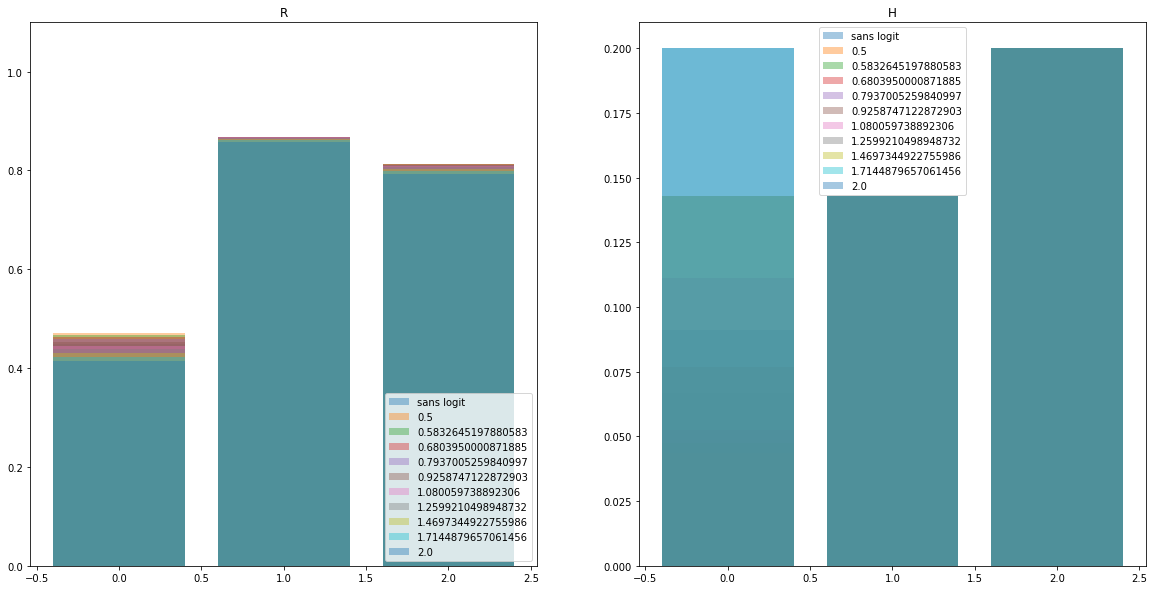

DC


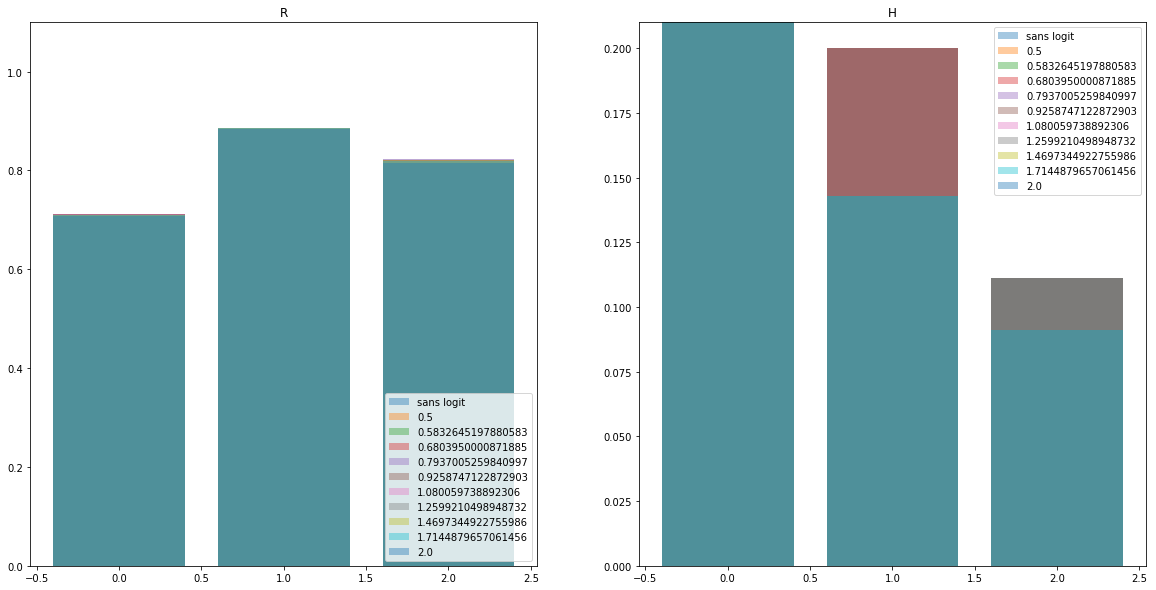

BMC


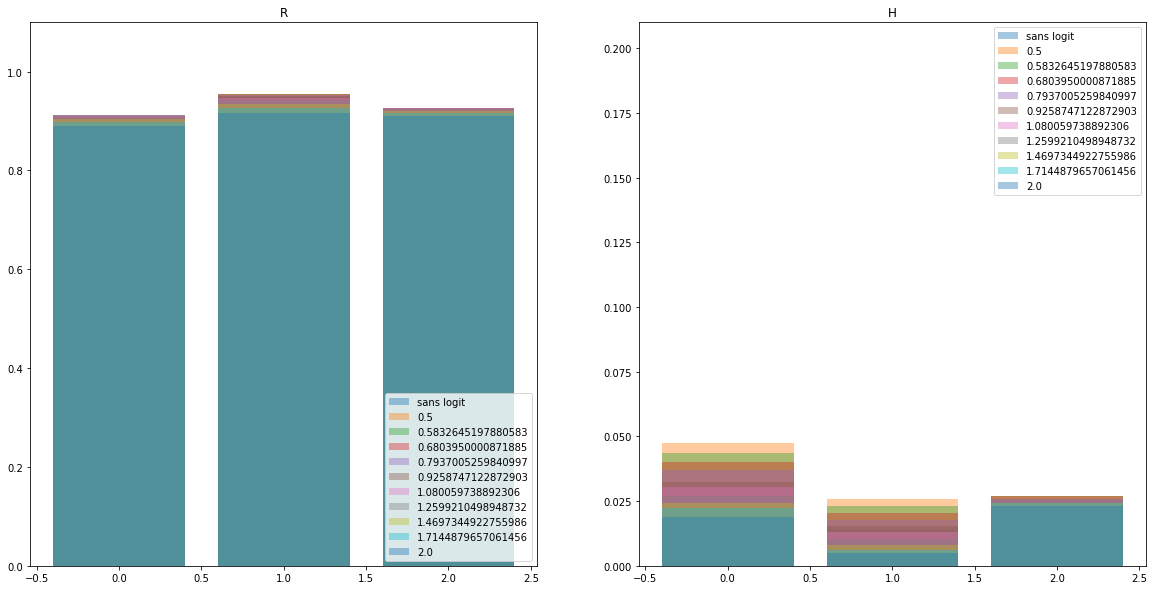

SR


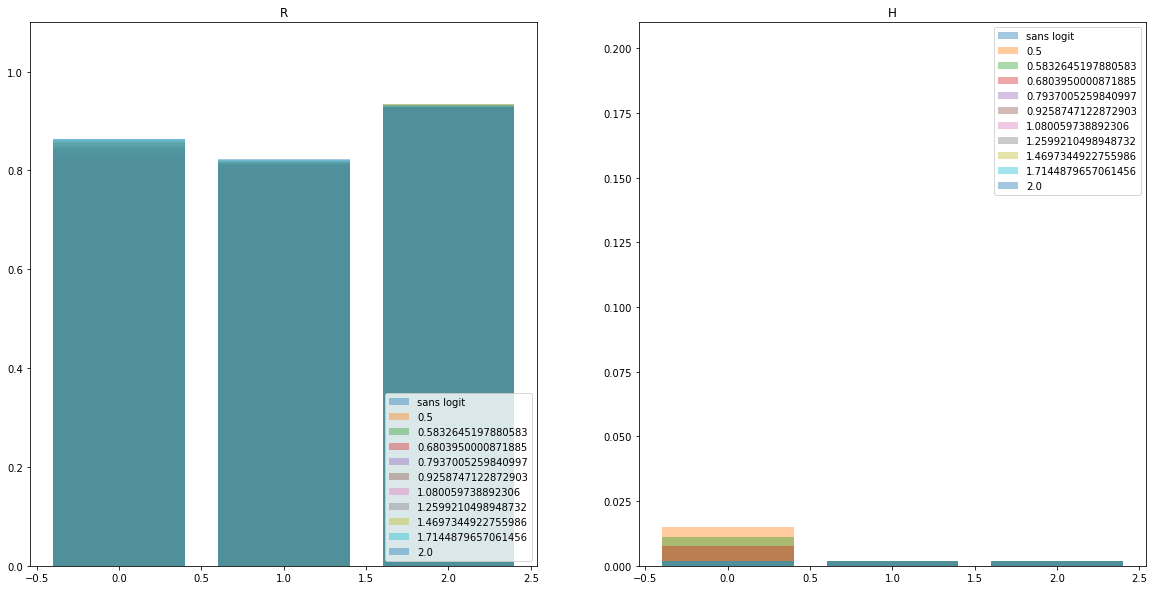

IP


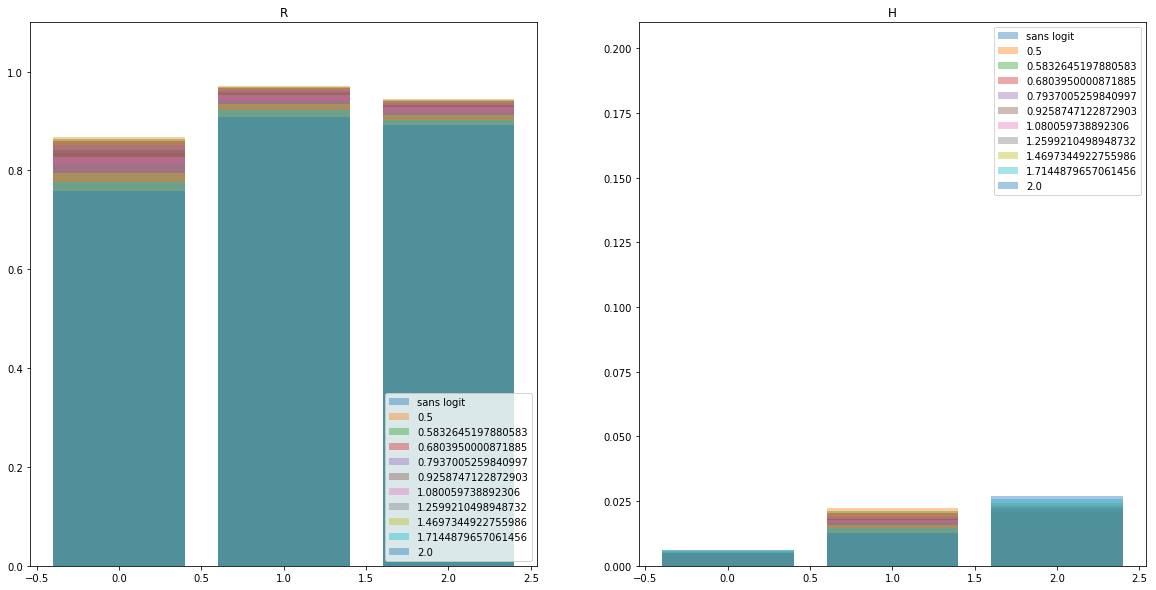

TN


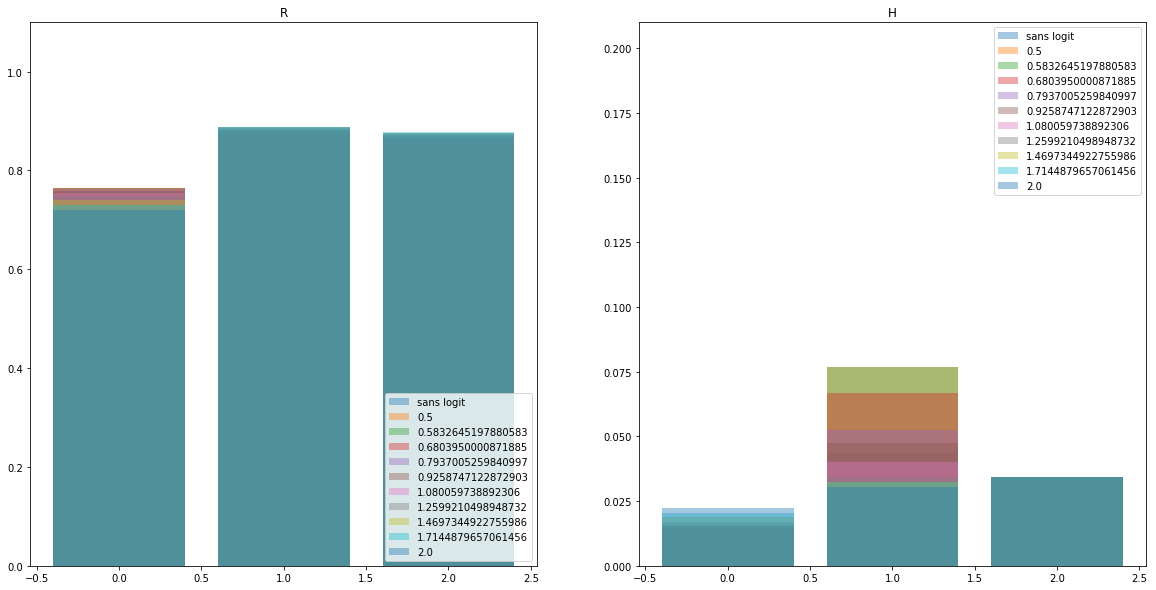

YK


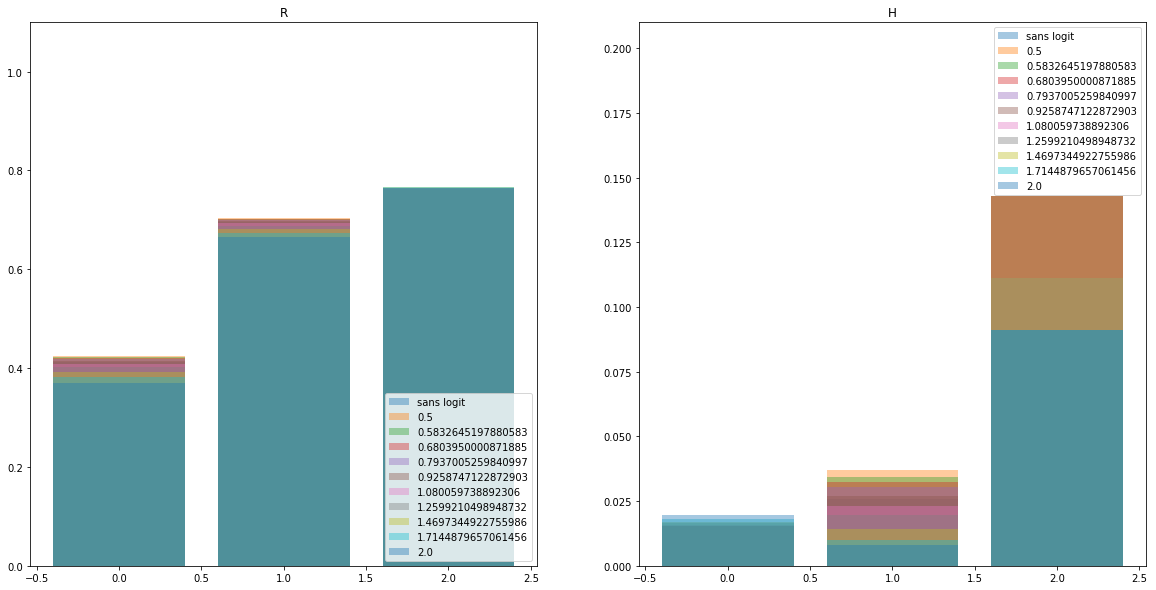

OP


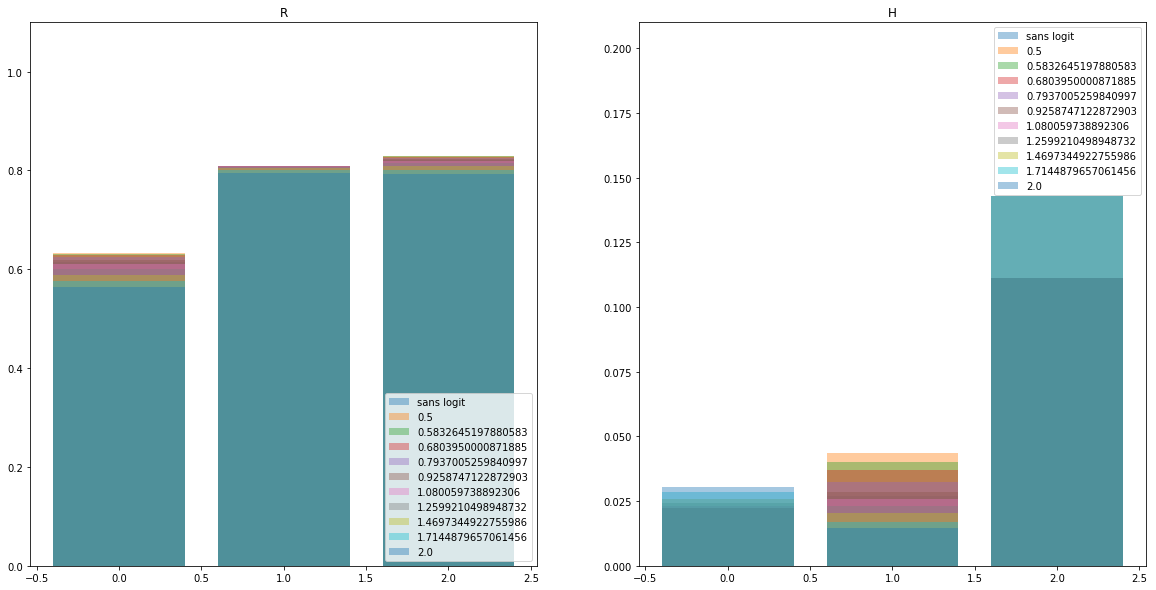

FM


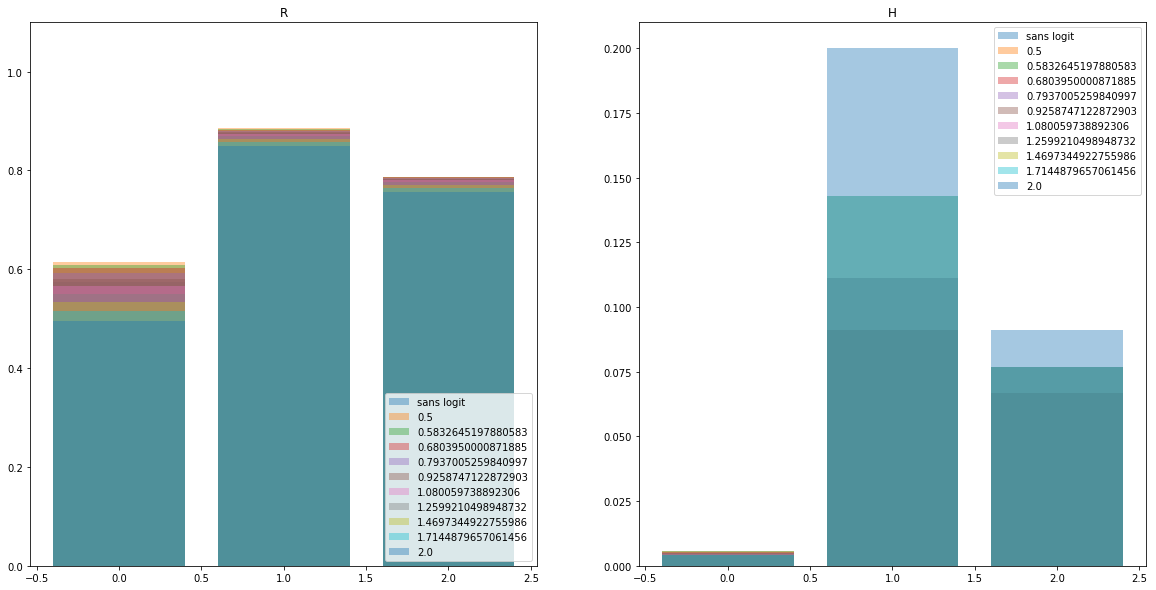

AM


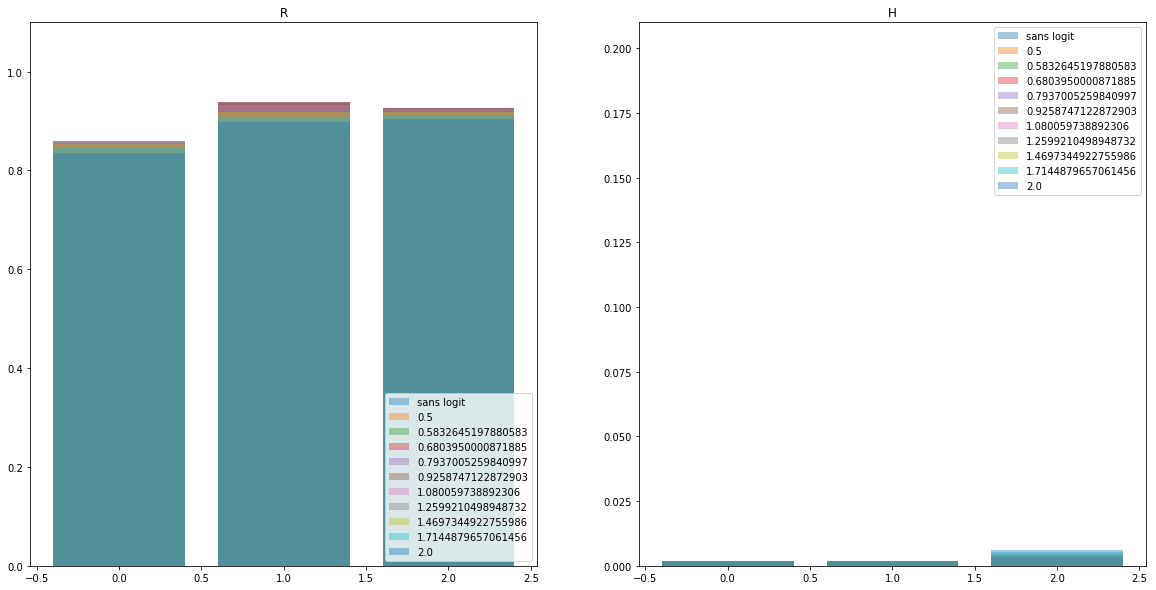

RS


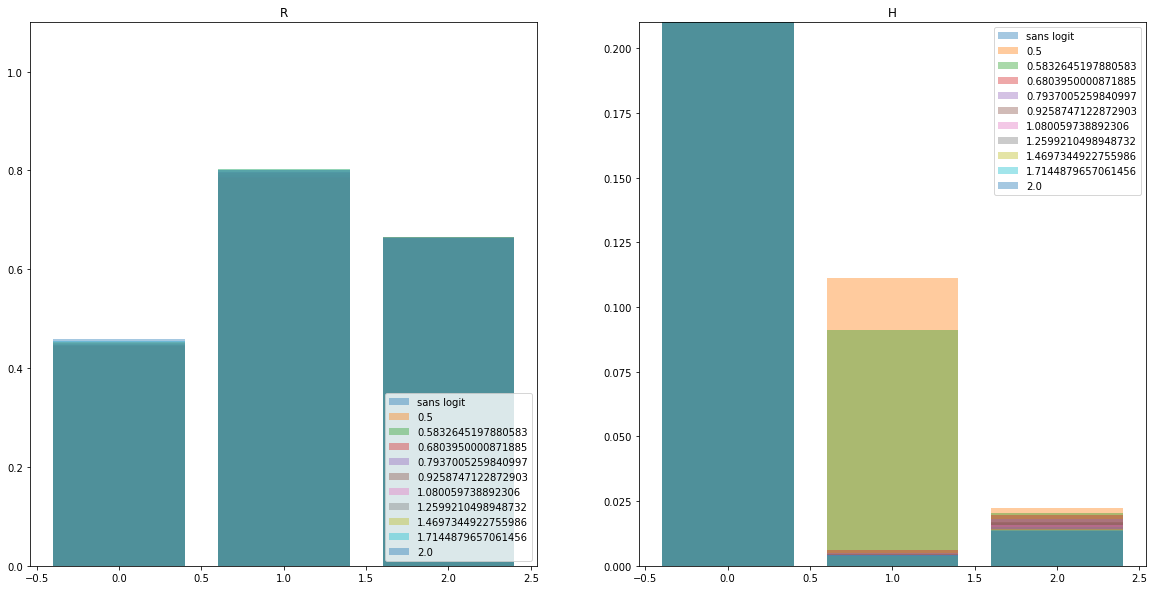

LB


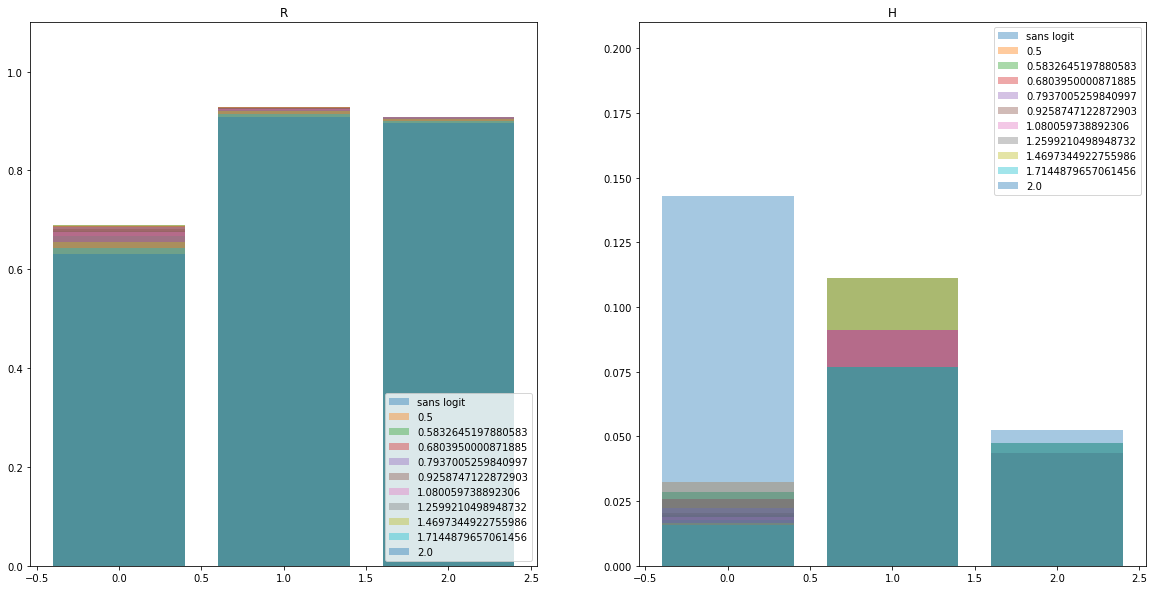

In [11]:
for num, s in enumerate(h_k_s.keys()) :
    h_k, r_k = h_k_s[s], r_k_s[s]
    print(s)
    
    fig, ax = plt.subplots(1,2,figsize=(2*10,10))

    ax[0].bar(np.arange(len(r_k[0])), r_k[0], alpha=0.4, label='sans logit')
    ax[1].bar(np.arange(len(h_k[0])), h_k[0], alpha=0.4, label='sans logit')

    for num, k in enumerate(np.logspace(-1, 1, 10, base=2)) :
        ax[0].bar(np.arange(len(r_k[num+1])), r_k[num+1], alpha=0.4, label=k)
        ax[1].bar(np.arange(len(h_k[num+1])), h_k[num+1], alpha=0.4, label=k)

    ax[0].legend(loc=4) ; ax[1].legend()
    ax[0].set_ylim(0, 1.1)
    #ax[1].set_ylim(min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
    ax[1].set_ylim(0, 0.21)
    ax[0].set_title('R') ; ax[1].set_title('H')
    plt.show()